# QR decompostion and the coherence matrix

This notebbook was the first attempt at getting some intuition into why approximating the eigenvalue decomposition of a coherence matrix using QR decompsition is a good idea.

The proposed idea for using QR decomposition to approximate the eigenvalue decomposition of a coherence matrix is as follows:
- Given a matrix $U$ with $n$ columns corresponding to the a discrete frequency of the fourier transform of $n$ time windows, we can compute the coherence matrix $C = |UU^H|^2$. The first step of the approximation is to compute the QR decomposition of $$U = QR$$
- Then the eigenvalues of the coherence matrix are approximated by the eigenvalues of the matrix $$RR^H$$

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import time
# from sklearn.utils.extmath import randomized_svd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [2]:
def loadBradyHShdf5(file,normalize='yes'):
    '''

    Parameters
    ----------
    file : str
        path to brady hotspring h5py data file
    normalize : str, optional
        "yes" or "no". Indicates whether or not to remove laser drift and 
        normalize. The default is 'yes'.

    Returns
    -------
    data : np array
        channel by samples numpy array of data
    timestamp_arr : numpy array
        array of the timestamps corresponding to the various samples in the 
        data. Timestamps for brady hotspring data are with respect to the 
        beginning time of the survey.

    '''
    
    with h5py.File(file,'r') as open_file: 
        dataset = open_file['das']
        time=open_file['t']
        data=np.array(dataset)
        timestamp_arr=np.array(time)
    data = np.transpose(data)
    if normalize=='yes':
        nSamples=np.shape(data)[1]
        # get rid of laser drift
        med = np.median(data,axis=0)
        for i in range(nSamples):
          data[:,i] = data[:,i] - med[i]
          
        max_of_rows = abs(data[:,:]).sum(axis=1)
        data = data/ max_of_rows[:, np.newaxis]
    return data, timestamp_arr

def windowed_spectra(data: np.array, subwindow_len: int,overlap,freq=None,sample_interval=1):
    """
    Calculate the frequency domain representation of data in windows.
    """

    win_start = 0
    window_samples = int(subwindow_len / sample_interval)
    total_samples = data.shape[-1]
    overlap = int(overlap/sample_interval)
    intervals = np.arange(window_samples, total_samples+1, window_samples, dtype=int) # break time series into windowed intervals

    win_end = intervals[0]

    absolute_spectra = np.fft.rfft(data[:,win_start:win_end])
    win_spectra = absolute_spectra[np.newaxis]

    while win_end < total_samples:
        win_start = win_end - overlap
        win_end = win_start + window_samples
        absolute_spectra = np.fft.rfft(data[:,win_start:win_end])
        win_spectra = np.append(
            win_spectra, absolute_spectra[np.newaxis], axis=0
        )
        # win_start = win_end
        
    
    frequencies = np.fft.rfftfreq(window_samples, sample_interval)

    return win_spectra, frequencies

def normalised_windowed_spectra(data: np.array, subwindow_len: int,overlap,freq=None,sample_interval=1):

    win_spectra, frequencies = windowed_spectra(data, subwindow_len,overlap,freq,sample_interval)
    
    # win_spectra = np.absolute(win_spectra)**2 # sub for next line
    # win_spectra = win_spectra * np.conjugate(win_spectra) # absolutes square of spectra. We need this if
    # we want to use the normalised spectra to calculate welch coherence.
    # normalizer = np.sum(win_spectra, axis=0)

    normalizer = np.sum(np.absolute(win_spectra)**2, axis=0)
    normalizer = np.tile(np.sqrt(normalizer),(win_spectra.shape[0],1,1))
    normalizer = normalizer.transpose(2,1,0)

    normalized_spectra = win_spectra.transpose(2,1,0) / normalizer

    return normalized_spectra, frequencies

def welch_coherence(data: np.array, subwindow_len: int,overlap,freq=None,sample_interval=1):
    """
    Calculate the coherence matrix at all (or particular frequencies: yet to be implemented)
    using the welch method.
    """

    win_spectra, frequencies = windowed_spectra(data, subwindow_len,overlap,freq,sample_interval)

    normalizer = np.sum(np.absolute(win_spectra)**2, axis=0)
    normalizer = np.tile(normalizer,(normalizer.shape[0],1,1))
    normalizer = normalizer * normalizer.transpose((1,0,2))
    normalizer = normalizer.transpose(2,1,0)

    welch_numerator = np.matmul(win_spectra.transpose(2,1,0), np.conjugate(win_spectra.transpose(2,0,1)))
    welch_numerator = np.absolute(welch_numerator)**2
    coherence = np.multiply(welch_numerator,1/normalizer)

    return coherence, frequencies



Load data

In [3]:
# file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083818.h5"
# data3,_ = loadBradyHShdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083848.h5"
data,_ = loadBradyHShdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083918.h5"
data2,_= loadBradyHShdf5(file,normalize='no')

# signalToUse=np.append(data[:,24976:],data2[:,:10000],axis=1)
data = np.append(data,data2,axis=1)
# data = np.append(data,data3,axis=1)
samples_per_sec=1000

C:\Users\issah\AppData\Local\Temp\ipykernel_38748\2162354552.py:26: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  data=np.array(dataset)
C:\Users\issah\AppData\Local\Temp\ipykernel_38748\2162354552.py:27: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  timestamp_arr=np.array(time)


Define coherence analyses parameters.

In [4]:
# start_ch = 1000
# nchannels = 3000
# start_ch = 4500
# nchannels = 1000
start_ch = 3100
nchannels = 2000
nsensors = 200
subwindow_len = 2
overlap = 0

Plot data

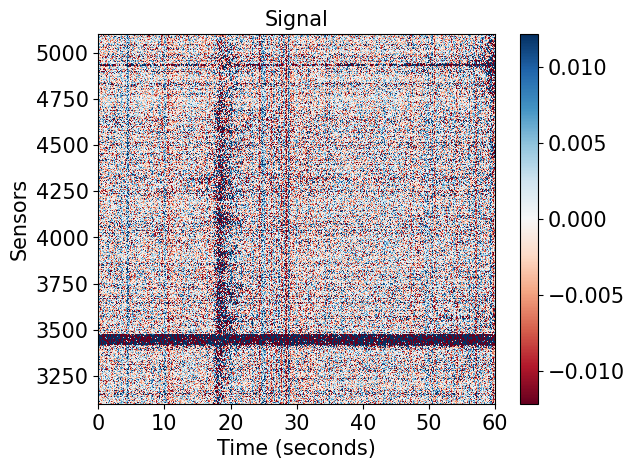

In [5]:
fsize=15
# pdata=data [:,25000:] # signalToUse[1900:3900]
# pdata = data[start_ch:nchannels+start_ch,25000:]
pdata = data[start_ch:nchannels+start_ch]

fig2 = plt.figure()
img2 = plt.imshow(pdata, cmap="RdBu", 
           vmin=-np.percentile(np.absolute(pdata),90), 
           vmax=np.percentile(np.absolute(pdata),90), aspect='auto', interpolation='none',
           extent=(0,len(pdata[0])/samples_per_sec, start_ch, start_ch + nchannels))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel('Time (seconds)',fontsize=fsize)
plt.ylabel('Sensors',fontsize=fsize)
plt.title('Signal',fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fsize)

Compute the coherence matrix

In [7]:
norm_win_spectra, frequencies = normalised_windowed_spectra(data[start_ch:nchannels+start_ch:int(nchannels/nsensors)], subwindow_len, overlap, sample_interval=0.001)
# norm_win_spectra, frequencies = normalised_windowed_spectra(data[start_ch:nchannels+start_ch:int(nchannels/nsensors)], 5, 2.5, sample_interval=0.001)

# welch_coherence = np.matmul(norm_win_spectra.transpose(2,1,0), np.conjugate(norm_win_spectra.transpose(2,0,1)))
welch_coherence_mat = np.matmul(norm_win_spectra, np.conjugate(norm_win_spectra.transpose(0,2,1)))
welch_coherence_mat = np.absolute(welch_coherence_mat)**2

Compute and visualize detection parameter across various frequencies.

In [8]:
fsize = 15
# num_frames = coherence2.shape[0]
# data_2use = welch_coherence_mat.real
# data_2use = np.absolute(welch_coherence_mat)**2
num_frames = int(welch_coherence_mat.shape[0]/2)

eig_ratios2 = np.empty(num_frames)
eig_ratios_qr = np.empty(num_frames)
eig_ratios_qr2 = np.empty(num_frames)
eig_ratios_qr_diag = np.empty(num_frames)
eig_ratios_qr2_diag = np.empty(num_frames)

for d in range(num_frames):
    eigenvals, _ = np.linalg.eig(welch_coherence_mat[d*2])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios2[d] = eigenvals[0]/np.sum(eigenvals)

    Q,R = np.linalg.qr(norm_win_spectra[d*2])
    qr_approx = np.sort(np.sum(np.absolute(R@R.transpose()), axis=0))[::-1]
    qr_approx_diag = np.sort(np.diag(np.absolute(R@R.transpose())))[::-1]
    # qr_approx = np.sort(np.sum(R@R.transpose(), axis=0))[::-1]
    eig_ratios_qr[d] = qr_approx[0]/np.sum(np.absolute(qr_approx))
    eig_ratios_qr_diag[d] = qr_approx_diag[0]/np.sum(np.absolute(qr_approx_diag))

    Q,R = np.linalg.qr(norm_win_spectra[d*2].T)
    qr_approx2_diag = np.sort(np.diag(np.absolute(R@R.transpose())))[::-1]
    qr_approx2 = np.sort(np.sum(np.absolute(R@R.transpose()), axis=0))[::-1]
    # qr_approx = np.sort(np.sum(R@R.transpose(), axis=0))[::-1]
    eig_ratios_qr2[d] = qr_approx2[0]/np.sum(np.absolute(qr_approx2))
    eig_ratios_qr2_diag[d] = qr_approx2_diag[0]/np.sum(np.absolute(qr_approx2_diag))

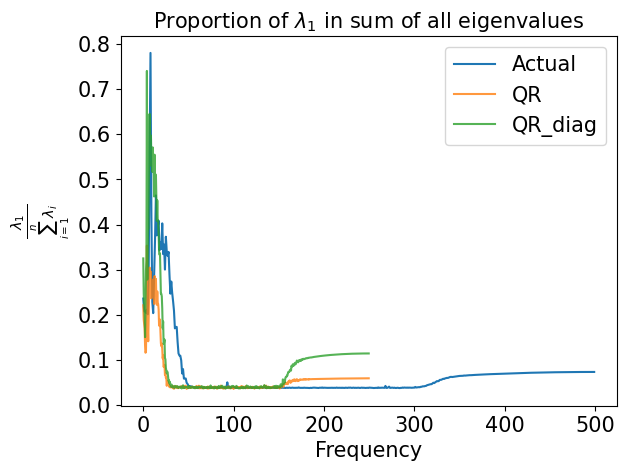

In [13]:
plt.plot(frequencies[2*np.array(range(num_frames))], eig_ratios2, label="Actual")
plt.plot(frequencies[:num_frames], eig_ratios_qr, label="QR",alpha=0.8)
# plt.plot(frequencies[:num_frames], eig_ratios_qr2, label="QR2",alpha=0.6)
plt.plot(frequencies[:num_frames], eig_ratios_qr_diag, label="QR_diag",alpha=0.8)
# plt.plot(frequencies[:num_frames], eig_ratios_qr2_diag, label="QR2_diag",alpha=0.6)
plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.legend(fontsize=fsize)

Display coherence matrix at a particular frequency.

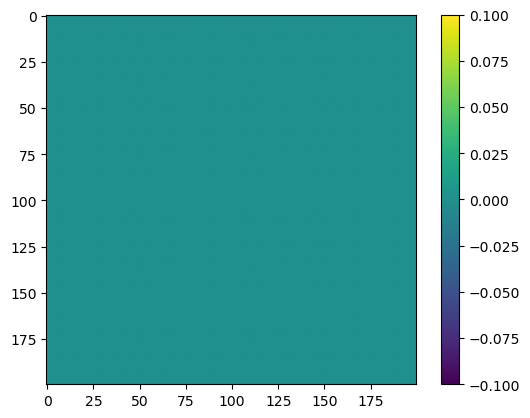

In [14]:
# welch_coherence_mat.shape
plt.imshow(welch_coherence_mat[30,:,:].imag)
plt.colorbar()

Compare methods of approximating eigen values do with a general timing test with random data.

In [15]:
RandA = norm_win_spectra[34,:,:]
nreps = 10

t0 = time.time()
for i in range(nreps):
    Q,R = np.linalg.qr(RandA)
    # qr_approx2 = np.sum(np.absolute(R@R.transpose()), axis=0)**2
    # qr_approx = np.diag(np.absolute(R@R.transpose()))**2
    qr_approx, _ = np.linalg.eig(R@R.transpose().conj())
    qr_approx2 = np.diag(np.absolute(R@R.transpose()))

    Q2,R2 = np.linalg.qr(RandA.T)
    # qr_approx2 = np.diag(np.absolute(R2@R2.transpose())) #**2
t1 = time.time()
qr_time = t1-t0
print("QR time: ", qr_time)

t0 = time.time()
for i in range(nreps):
    coherence_mat = np.absolute(RandA@np.conjugate(RandA.transpose()))**2
    eigenvals, _ = np.linalg.eig(coherence_mat)
t1 = time.time()
eig_time = t1-t0

print("Eigenvalue time: ", eig_time)

QR time:  0.06032419204711914
Eigenvalue time:  0.6327426433563232


Plot the estimated eigen values.

c:\Users\issah\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


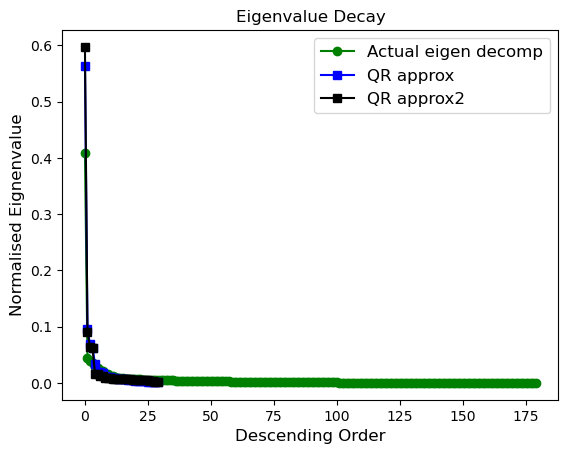

In [16]:
fsize = 12
qr_approx = np.sort(qr_approx)[::-1]
qr_approx2 = np.sort(qr_approx2)[::-1]
# qr_approx = np.sort(np.sum(R@R.transpose(), axis=0))[::-1]
qr_approx = qr_approx/np.sum(np.absolute(qr_approx))
qr_approx2 = qr_approx2/np.sum(np.absolute(qr_approx2)) 

actual_eigenval = np.sort(eigenvals)[::-1]
actual_eigenval = actual_eigenval/np.sum(actual_eigenval)

plt.plot(actual_eigenval[:6*len(qr_approx)], "g-o", label="Actual eigen decomp")
plt.plot(qr_approx, "b-s", label="QR approx")
plt.plot(qr_approx2, "k-s", label="QR approx2")

plt.xlabel('Descending Order',fontsize=fsize)
plt.ylabel('Normalised Eignenvalue',fontsize=fsize)
plt.title('Eigenvalue Decay',fontsize=fsize)
# plt.yscale('log')
plt.legend(fontsize=fsize)

## Distribution of points in space

Plot various columns of the coherence matrix to get a feel of the distribution of these points in space. The idea is to see if most of the points are clustered in any particular direction. This can be done easily if we have 2 dimensions. Since we do not have that luxurry, the next couple of cells will try to get some intuition into the distribution of the points in space by plotting in different ways.

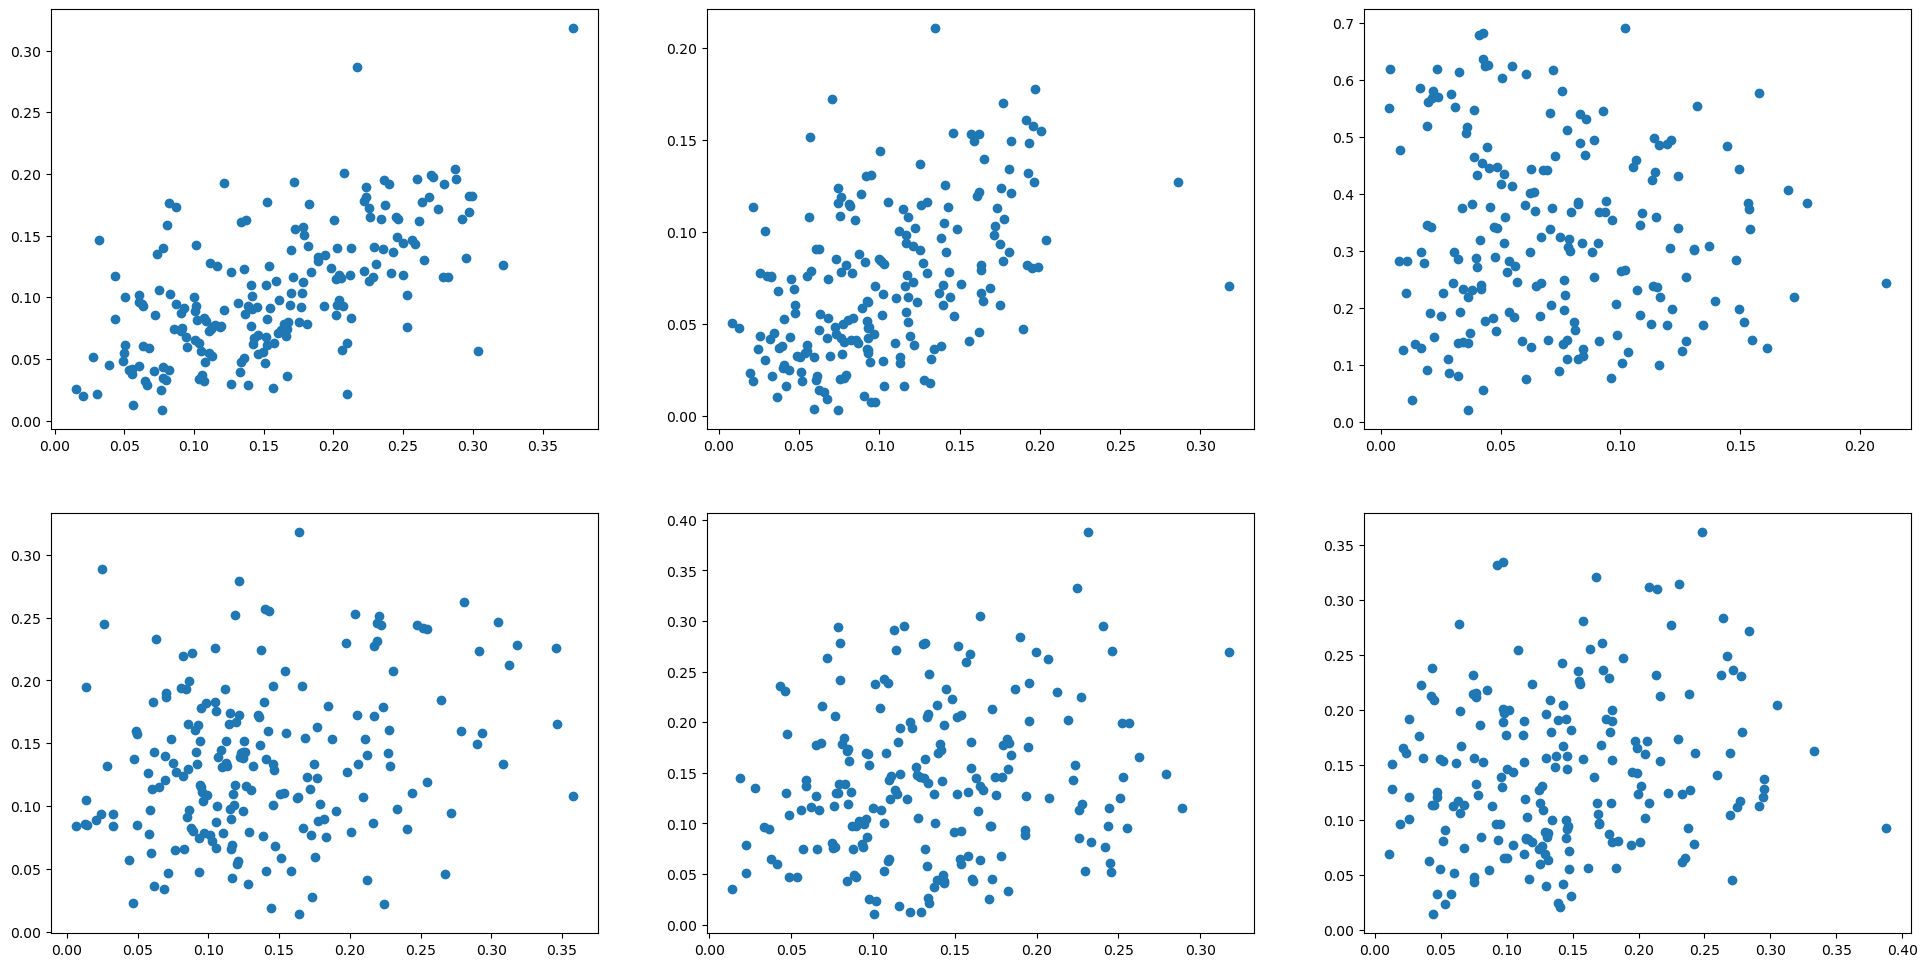

In [12]:
# plt.matshow(np.log10(welch_coherence_mat[0,:,:]))
# plt.matshow(np.abs(norm_win_spectra[0,:,:]))
f_index = 30
shift = 1

plt.figure(figsize=(24,12))
plt.subplot(2,3,1)
plt.plot(np.abs(norm_win_spectra[f_index,:,3])*shift, np.abs(norm_win_spectra[f_index,:,4])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,2)
plt.plot(np.abs(norm_win_spectra[f_index,:,4])*shift, np.abs(norm_win_spectra[f_index,:,5])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,3)
plt.plot(np.abs(norm_win_spectra[f_index,:,5])*shift, np.abs(norm_win_spectra[f_index,:,6])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)

f_index = 400
plt.subplot(2,3,4)
plt.plot(np.abs(norm_win_spectra[f_index,:,3])*shift, np.abs(norm_win_spectra[f_index,:,4])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,5)
plt.plot(np.abs(norm_win_spectra[f_index,:,4])*shift, np.abs(norm_win_spectra[f_index,:,5])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,6)
plt.plot(np.abs(norm_win_spectra[f_index,:,5])*shift, np.abs(norm_win_spectra[f_index,:,6])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)

Make a 3D plot of some columns the coherence matrix.

In [13]:
f_index = 30
shift = 1

# Create a list of vectors
vectors = [
    np.array([1, 2, 3]),
    np.array([4, 5, 6]),
    np.array([7, 8, 9]),
    # Add more vectors as needed
]

points = np.abs(norm_win_spectra[f_index,:,(4,5,6)])*shift
vectors = points.T

# Extract coordinates from vectors
x_coords = [vector[0] for vector in vectors]
y_coords = [vector[1] for vector in vectors]
z_coords = [vector[2] for vector in vectors]

# Create a 3D scatter plot
fig = go.Figure()

# Add scatter points for each vector
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers'))

# Set layout properties
fig.update_layout(scene=dict(aspectmode="cube", xaxis=dict(title="X"), yaxis=dict(title="Y"), zaxis=dict(title="Z")),
                  margin=dict(l=0, r=0, b=0, t=0))



Plot the approximation of the eigenvalues using the QR decomposition of $U$ and $U^T$. 

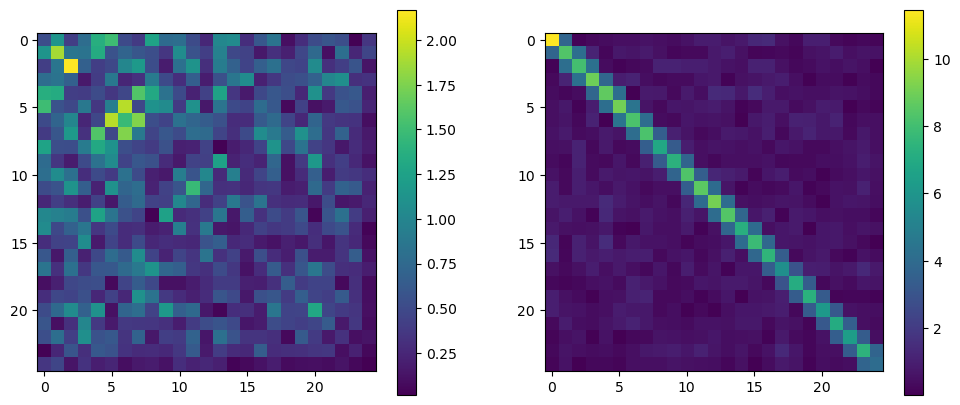

In [46]:
RandA = norm_win_spectra[400,:,:]
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
Q1,R1 = np.linalg.qr(RandA.T)
# plt.matshow(np.abs(R1@R1.T))
plt.imshow(np.abs(R1@R1.T))
plt.colorbar()
plt.subplot(1,2,2)
Q1,R1 = np.linalg.qr(RandA)
plt.imshow(np.abs(R1@R1.T))
plt.colorbar()
# plt.subplot(1,3,3)

0.05925514836392593


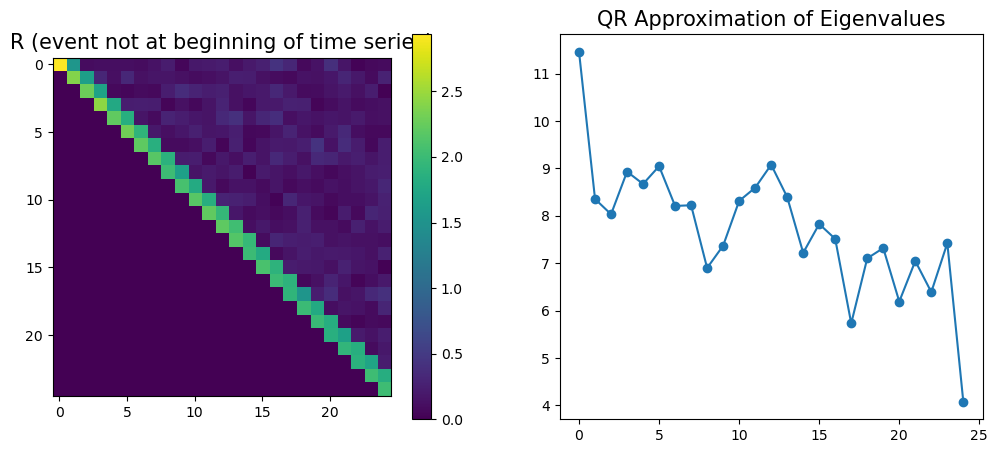

In [47]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(np.abs(R1))
plt.colorbar()
plt.title('R (event not at beginning of time series)', fontsize=15)
plt.subplot(1,2,2)
# plt.plot(frequencies)
qr_ = np.diag(np.absolute(R1@R1.transpose()))
plt.plot(qr_, '-o')
plt.title('QR Approximation of Eigenvalues', fontsize=15)
print(np.max(qr_)/np.sum(np.absolute(qr_)))

0.10043508734031238


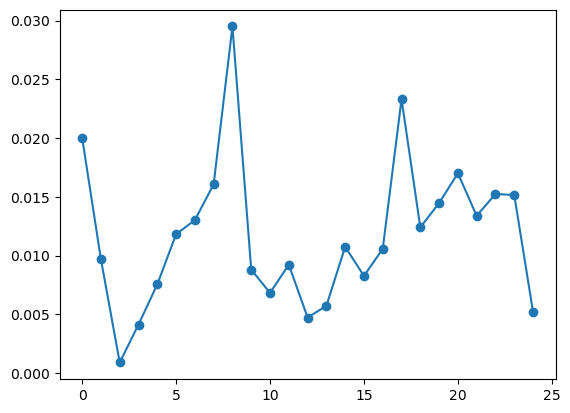

In [48]:
# for a in range(RandA.shape[1]):
# for a in range(10, 16):
#     plt.plot(np.abs(RandA[:,a]), label=str(a))

# plt.legend()
mean_RandA = np.abs(np.mean(RandA, axis=0))
plt.plot(np.abs(np.mean(RandA, axis=0)), '-o')
print(np.max(mean_RandA)/np.sum(np.absolute(mean_RandA)))

Test to see if the amount of enery within $U$ is enough to approximate the detection which would otherwise be done with the eigenvalues of the coherence matrix.

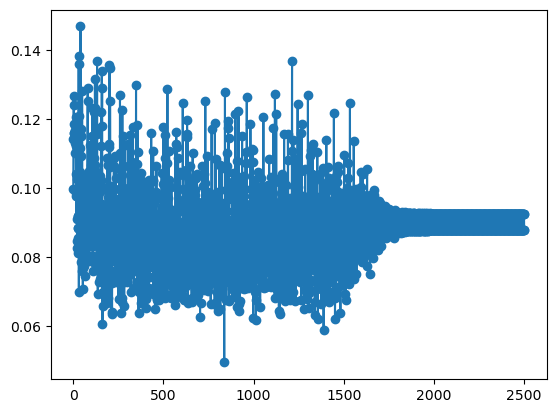

In [49]:
apprxs = []
for a in range(len(norm_win_spectra)):
    mean_ = np.abs(np.mean(norm_win_spectra[a,:,:], axis=0))
    apprxs.append(np.max(mean_)/np.sum(np.absolute(mean_)))

plt.plot(apprxs, '-o')

Find the angles between the columns of the $U$ matrix.

C:\Users\issah\AppData\Local\Temp\ipykernel_40696\1515664698.py:8: RuntimeWarning: invalid value encountered in arccos
  angles[i,j] = np.arccos(np.dot(np.absolute(norm_win_spectra[f_index,:,i]), np.absolute(norm_win_spectra[f_index,:,j]))/(np.linalg.norm(np.absolute(norm_win_spectra[f_index,:,i]))*np.linalg.norm(np.absolute(norm_win_spectra[f_index,:,j]))))


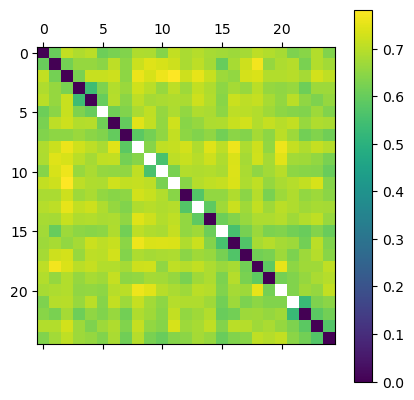

In [51]:
f_index = 400
wins = norm_win_spectra.shape[2]
angles = np.zeros((wins,wins))
for i in range(wins):
    for j in range(wins):
        # angles[i,j] = np.arccos(np.dot(norm_win_spectra[f_index,:,i], norm_win_spectra[f_index,:,j])/(np.linalg.norm(norm_win_spectra[f_index,:,i])*np.linalg.norm(norm_win_spectra[f_index,:,j])))
        # angles[i,j] = np.dot(norm_win_spectra[f_index,:,i], norm_win_spectra[f_index,:,j])/(np.linalg.norm(norm_win_spectra[f_index,:,i])*np.linalg.norm(norm_win_spectra[f_index,:,j]))
        angles[i,j] = np.arccos(np.dot(np.absolute(norm_win_spectra[f_index,:,i]), np.absolute(norm_win_spectra[f_index,:,j]))/(np.linalg.norm(np.absolute(norm_win_spectra[f_index,:,i]))*np.linalg.norm(np.absolute(norm_win_spectra[f_index,:,j]))))

plt.matshow(angles)
plt.colorbar()

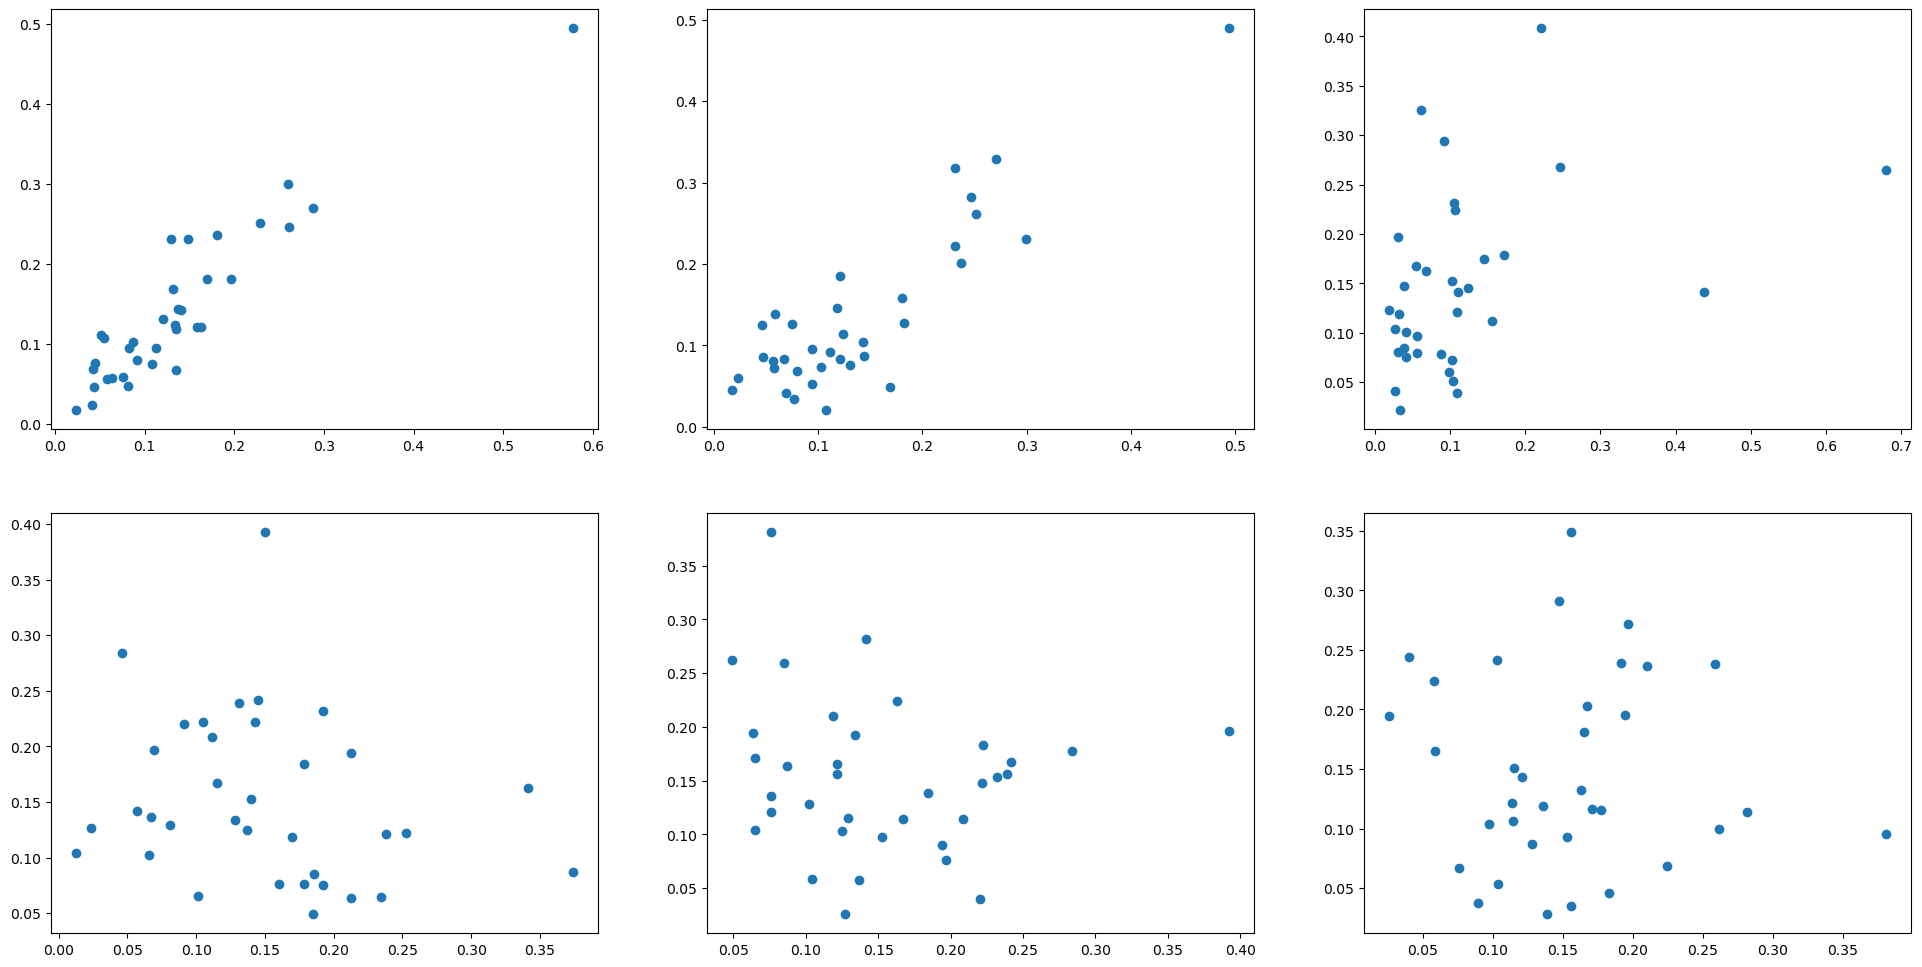

In [11]:
# plt.matshow(np.log10(welch_coherence_mat[0,:,:]))
# plt.matshow(np.abs(norm_win_spectra[0,:,:]))
f_index = 30
shift = 1

plt.figure(figsize=(24,12))
plt.subplot(2,3,1)
plt.plot(np.abs(norm_win_spectra[f_index,3,:])*shift, np.abs(norm_win_spectra[f_index,4,:])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,2)
plt.plot(np.abs(norm_win_spectra[f_index,4,:])*shift, np.abs(norm_win_spectra[f_index,5,:])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,3)
plt.plot(np.abs(norm_win_spectra[f_index,10,:])*shift, np.abs(norm_win_spectra[f_index,12,:])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)

f_index = 400
plt.subplot(2,3,4)
plt.plot(np.abs(norm_win_spectra[f_index,3,:])*shift, np.abs(norm_win_spectra[f_index,4,:])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,5)
plt.plot(np.abs(norm_win_spectra[f_index,4,:])*shift, np.abs(norm_win_spectra[f_index,5,:])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,6)
plt.plot(np.abs(norm_win_spectra[f_index,5,:])*shift, np.abs(norm_win_spectra[f_index,6,:])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)

In [12]:
f_index = 30
shift = 1

# Create a list of vectors
vectors = [
    np.array([1, 2, 3]),
    np.array([4, 5, 6]),
    np.array([7, 8, 9]),
    # Add more vectors as needed
]

points = np.abs(norm_win_spectra[f_index,(4,5,6),:])*shift
vectors = points.T

# Extract coordinates from vectors
x_coords = [vector[0] for vector in vectors]
y_coords = [vector[1] for vector in vectors]
z_coords = [vector[2] for vector in vectors]

# Create a 3D scatter plot
fig = go.Figure()

# Add scatter points for each vector
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers'))

# Set layout properties
fig.update_layout(scene=dict(aspectmode="cube", xaxis=dict(title="X"), yaxis=dict(title="Y"), zaxis=dict(title="Z")),
                  margin=dict(l=0, r=0, b=0, t=0))

### Add random noise to the data and see how the approximation of the eigenvalues of the coherence matrix using the QR decomposition of $U$ is affected.

In [ ]:
# random matrix with same size as norm_win_spectra
random_A = np.random.rand(*norm_win_spectra.shape)
random_A = random_A + 1j*np.random.rand(*norm_win_spectra.shape) + norm_win_spectra
RandAa = random_A[350,:,:]
welch_coherence_mat_rand = np.absolute(RandAa@np.conjugate(RandA.transpose()))**2

eigenvals, _ = np.linalg.eig(welch_coherence_mat_rand)
eigenvals = np.sort(eigenvals)[::-1]
eigenvals = eigenvals/np.sum(eigenvals)

welch_coherence_mat_rand = np.absolute(RandAa@np.conjugate(RandA.transpose()))**2

rand_eigenvals, _ = np.linalg.eig(welch_coherence_mat_rand)
rand_eigenvals = np.sort(rand_eigenvals)[::-1]
rand_eigenvals = rand_eigenvals/np.sum(rand_eigenvals)


Q,R = np.linalg.qr(RandA)
# qr_approx2 = np.sum(np.absolute(R@R.transpose()), axis=0)**2
qr_approx = np.diag(np.absolute(R@R.transpose()))**2
qr_approx = qr_approx/np.sum(np.absolute(qr_approx))

Q,R = np.linalg.qr(RandAa)
# qr_approx2 = np.sum(np.absolute(R@R.transpose()), axis=0)**2
qr_approx_rand = np.diag(np.absolute(R@R.transpose()))**2
qr_approx_rand = qr_approx_rand/np.sum(np.absolute(qr_approx_rand))

# rand_qr_approx = np.diag(np.absolute(
plt.plot(eigenvals, "r-o", label="Actual eigen decomp")
# plt.plot(rand_eigenvals, "g-o", label="rand plus Actual eigen decomp")
plt.plot(qr_approx, "b-s", label="QR approx")
plt.plot(qr_approx_rand, "k-s", label="rand plus QR approx")
plt.xlabel('Decending Order',fontsize=fsize)
plt.ylabel('Normalised Eignenvalue',fontsize=fsize)
plt.title('Eigenvalue Decay',fontsize=fsize)
plt.legend(fontsize=fsize)

In [ ]:
fsize = 15
# num_frames = coherence2.shape[0]
# data_2use = welch_coherence_mat.real
# data_2use = np.absolute(welch_coherence_mat)**2
# num_frames = int(data_2use.shape[0]/2)

num_frames = int(norm_win_spectra.shape[0]/2)

eig_ratios2 = np.empty(num_frames)
eig_ratios_qr = np.empty(num_frames)
eig_ratios_qr2 = np.empty(num_frames)
eig_ratios_qr_diag = np.empty(num_frames)
eig_ratios_qr2_diag = np.empty(num_frames)
eig_ratios_qr_rand = np.empty(num_frames)
eig_ratios_svd = np.empty(num_frames)
eig_ratios_rsvd = np.empty(num_frames)
for d in range(num_frames):
    RandA = norm_win_spectra[d*2]
    coherence_mat = np.absolute(RandA@np.conjugate(RandA.transpose()))**2
    eigenvals, _ = np.linalg.eig(coherence_mat)
    # eigenvals, _ = np.linalg.eig(data_2use[d*2])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios2[d] = eigenvals[0]/np.sum(eigenvals)

    Q,R = np.linalg.qr(norm_win_spectra[d*2])
    qr_approx = np.sort(np.sum(np.absolute(R@R.transpose()), axis=0))[::-1]
    qr_approx_diag = np.sort(np.diag(np.absolute(R@R.transpose())))[::-1]
    # qr_approx = np.sort(np.sum(R@R.transpose(), axis=0))[::-1]
    eig_ratios_qr[d] = qr_approx[0]/np.sum(np.absolute(qr_approx))
    eig_ratios_qr_diag[d] = qr_approx_diag[0]/np.sum(np.absolute(qr_approx_diag))

    Q,R = np.linalg.qr(norm_win_spectra[d*2].T)
    qr_approx2_diag = np.sort(np.diag(np.absolute(R@R.transpose())))[::-1]
    # qr_approx2 = np.sort(np.sum(np.absolute(R@R.transpose()), axis=0))[::-1]
    qr_approx2, _ = np.linalg.eig(R@(R.transpose().conj()))
    # qr_approx = np.sort(np.sum(R@R.transpose(), axis=0))[::-1]
    eig_ratios_qr2[d] = qr_approx2[0]/np.sum(np.absolute(qr_approx2))
    eig_ratios_qr2_diag[d] = qr_approx2_diag[0]/np.sum(np.absolute(qr_approx2_diag))

    Q,R = np.linalg.qr(random_A[d*2])
    # qr_approx2 = np.sum(np.absolute(R@R.transpose()), axis=0)**2
    qr_approx_rand = np.diag(np.absolute(R@R.transpose()))**2
    eig_ratios_qr_rand[d] = qr_approx_rand[0]/np.sum(np.absolute(qr_approx_rand))

In [ ]:
plt.plot(eig_ratios2[:800], "r-", label="Actual eigen decomp")
# plt.plot(eig_ratios_qr[:800], "b-", label="QR approx")
plt.plot(eig_ratios_qr2[:800], "k-", label="QR approx2")
# plt.plot(eig_ratios_qr_diag[:800], "g-", label="QR approx diag")
# plt.plot(eig_ratios_qr2_diag[:800], "y-", label="QR approx2 diag")
# plt.plot(eig_ratios_qr_rand[:800], "m-", label="QR approx rand")

plt.xlabel('Descending Order',fontsize=fsize)
plt.ylabel('Detection Significance',fontsize=fsize)
plt.title('Detections',fontsize=fsize)
plt.legend(fontsize=fsize)